# MRI-3T-rsfMRI

**Overview**

This notebook will examine 3T MRI rsfMRI measures projected onto hippocampal surfaces and averaged across 99 subjects. We will then take a closer look at functional connectivity (FC) of the hippocampus, and break it down into primary Gradients.

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import hippomaps as hm
from brainspace.gradient import GradientMaps
from brainspace.datasets import load_conte69, load_parcellation
from brainspace.plotting import plot_hemispheres
from brainspace.mesh.mesh_io import read_surface

In [25]:
# config

useCheckpoints = True # this will download and use checkpoint numpy array data instead of mapping local data to hippocampal surfaces 
if useCheckpoints:
    hm.fetcher.get_tutorialCheckpoints(['MRI-7T-rsfMRI.npy', 'MRI-7T-rsfMRI-FC.npy'])
    
# locate input data
micapipe_dir = '/data/mica3/BIDS_PNI/derivatives/micapipe_v0.2.0'
hippunfold_dir = '/data/mica3/BIDS_PNI/derivatives/hippunfold_v1.3.0_supersession/hippunfold'
tmp_dir = 'tmp_7TrsfMRI'

# define which subjects and surfaces to examine
subs = ['PNC002', 'PNC003', 'PNC006', 'PNC007', 'PNC009', 'PNC010', 'PNC015', 'PNC016', 'PNC018', 'PNC019']
ses = '01'
hemis = ['L','R']
labels = ['hipp']# ,'dentate'] 
den='2mm'
sigma = 1 # Gaussian smoothing kernal sigma (mm) to apply to surface data
timepoints = 275 # number of volumes
TR = 0.6 # repetition time (seconds)

# get expected number of vertices and their indices
nV,iV = hm.config.get_nVertices(labels,den) 

# Load neocortical surfaces for visualzation 
# 3. Load neocortical surfaces for visualzation
parcL, parcR = load_parcellation('schaefer')
c69_inf_lh, c69_inf_rh = load_conte69()
nP = len(np.unique(parcL))-1 # number of neocortical parcels (one hemisphere)
parc = np.concatenate((parcL,parcR))

## 0) Map rsfMRI data to hippocampal surfaces

As in all tutorials here, this step is OPTIONAL, and provides an example of how data can be mapped to hippocampal surfaces outside of python (using ANTs and/or wb_command). This relies on having the data stored locally, and should be considered example code. This code may differ depending on where/how your data is stored and formatted, and so may require some customization for new projects. For the purposes of this tutorial, we provide a matrix of loaded data at the end, so skip to the next step).

In this example, we loop through subjects and hemipsheres, and transform hippocampal surfaces to space-func, sample volumetric timeseries data onto hippocampal surfaces, then apply smoothing. Finally, we load the data from all surfaces into a single matrix.

In [ ]:
if not useCheckpoints:

    # Note that all data is not yet aligned in space-T1w AKA space-nativepro, we we need to apply transforms to make it so. In micapipe, this involves two affines and a warp transform. 

    # intialize the matrix for loading data into
    cdata_hipp = np.ones((nV,len(hemis),timepoints,len(subs)))*np.nan
    !mkdir -p {tmp_dir}

    for s,sub in enumerate(subs):
        # convert affines
        cmd1a = f'/data_/mica1/01_programs/c3d-1.0.0-Linux-x86_64/bin/c3d_affine_tool '\
            f'-itk {micapipe_dir}/sub-{sub}/ses-{ses}/xfm/sub-{sub}_ses-{ses}_from-me_task-rest_bold_to-nativepro_mode-image_desc-affine_0GenericAffine.mat '\
            f'-o {tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine0.txt'
        !{cmd1a}
        cmd1b = f'/data_/mica1/01_programs/c3d-1.0.0-Linux-x86_64/bin/c3d_affine_tool '\
            f'-itk {micapipe_dir}/sub-{sub}/ses-{ses}/xfm/sub-{sub}_ses-{ses}_from-nativepro_func_to-me_task-rest_bold_mode-image_desc-SyN_0GenericAffine.mat '\
            f'-inv '\
            f'-o {tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine1.txt'
        !{cmd1b}

        for h,hemi in enumerate(hemis):
            for l,label in enumerate(labels):
                #apply affines
                cmd2a = f'wb_command -surface-apply-affine '\
                    f'{hippunfold_dir}/sub-{sub}/surf/sub-{sub}_hemi-{hemi}_space-T1w_den-{den}_label-{label}_midthickness.surf.gii '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine0.txt '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff0.surf.gii'
                !{cmd2a}
                cmd2b = f'wb_command -surface-apply-affine '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff0.surf.gii '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine1.txt '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff1.surf.gii'
                !{cmd2b}
                # apply warp (Note this is actually the INVERSE warp)
                cmd3 = f'wb_command -surface-apply-warpfield '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff1.surf.gii '\
                    f'{micapipe_dir}/sub-{sub}/ses-{ses}/xfm/sub-{sub}_ses-{ses}_from-nativepro_func_to-me_task-rest_bold_mode-image_desc-SyN_1Warp.nii.gz '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_deform.surf.gii'
                !{cmd3}

                # sample
                cmd4 = f'wb_command -volume-to-surface-mapping '\
                    f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-me_task-rest_bold/volumetric/sub-{sub}_ses-{ses}_space-func_desc-me_preproc.nii.gz '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_deform.surf.gii '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_rsfMRI.func.gii '\
                    f'-enclosing'
                !{cmd4}

                # smooth
                cmd5 = f'wb_command -metric-smoothing '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_deform.surf.gii ' \
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_rsfMRI.func.gii '\
                    f'{sigma} '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_rsfMRI_smooth.func.gii '
                !{cmd5}

                # now load the data!
                func = nib.load(f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_rsfMRI_smooth.func.gii')
                for k in range(timepoints):
                    cdata_hipp[iV[l],h,k,s] = func.darrays[k].data
                    
    np.save("../checkpoints/MRI-7T-rsfMRI",cdata_hipp, allow_pickle=True)
    !rm -r {tmp_dir}

## 1) Intrinsic Timescale of hippocampal rsfMRI

Our data is now organized into a single matrix of (number of vertices nV) x (number of hemsipheres 2) x (timepoints) x (number of subjects)

Intrinsic timescale is a measure of how long it takes for the temporal autocorrelation of rsfMRI data to decay beyond a treshold. In this case, until an autocorrelation of 0 is reached. 

In [ ]:
cdata_hipp = np.load("../checkpoints/MRI-7T-rsfMRI.npy")

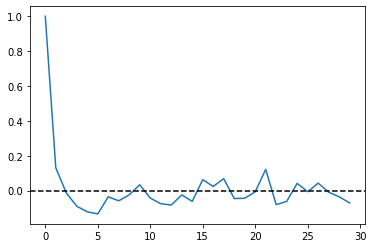

In [28]:
# sample a random vertex to view its autocorrelation function (acf)
t = cdata_hipp[5,0,:,0]
m = np.mean(t)
var = np.var(t)
ndat = t - m
acf = np.correlate(ndat, ndat, 'full')[len(ndat)-1:] 
acf = acf / var / len(ndat)
plt.plot(acf[:30])
plt.axhline(y = 0, color = 'k', linestyle = '--') 

In [29]:
def IntrinsicTimescale(data, TR=1, threshold=0):
    '''computes instrinsic timescale - the AUC of the autocorrelation up to the point 
    where the autocorrelation reaches threshold. 
    Input
      img: input ND data, time being the last dimension
    '''
    shp = data.shape
    i = data.reshape(-1, shp[-1])
    out = np.zeros(i.shape[0])
    for v in range(i.shape[0]):
        m = np.mean(i[v,:])
        var = np.var(i[v,:])
        ndat = i[v,:] - m
        acf = np.correlate(ndat, ndat, 'full')[len(ndat)-1:] 
        acf = acf / var / len(ndat)
        f = np.where(acf<=threshold)[0]
        if len(f)==0:
            out[v] = np.nan
        else:
            out[v] = f[0]
    out = np.reshape(out,shp[:-1])*TR
    return out

In [30]:
IntTS = np.ones((nV,len(hemis),len(subs)))*np.nan
for s,sub in enumerate(subs):
    IntTS[:,:,s] = IntrinsicTimescale(cdata_hipp[:,:,:,s],TR)

/export03/data/opt/BrainSpace/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


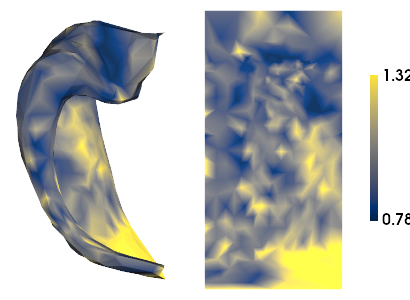

In [31]:
hm.plotting.surfplot_canonical_foldunfold(np.nanmean(IntTS,axis=(1,2)), den='2mm', hemis=['L'], labels=labels, unfoldAPrescale=True, tighten_cwindow=True, cmap='cividis', share='row', color_bar='right', embed_nb=True)

(0.0, 15.0)

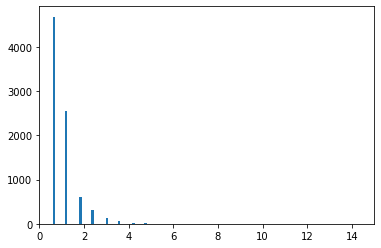

In [32]:
plt.hist(IntTS.flatten(),bins=50);
plt.xlim([0,15])

Note that in many cases, the ACF drops below 0 after only 1 TR, meaning there is no autocorrelation. This is slightly not ideal, but seems to be concistent with other neocortical data and other studies. 

## 2) Calculate Regional Homogeneity

Regional homogeneity is a measure of local functional connectivity, or how similar each vertex is to all nieghbours across time. Here we will start with an illustrative example

/data/mica1/01_programs/tmp/ipykernel_23749/2855178037.py:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  pc = art3d.Poly3DCollection(v[f], faceColor=[0, 0, 0, 0], edgeColor=[0,0,0,1])


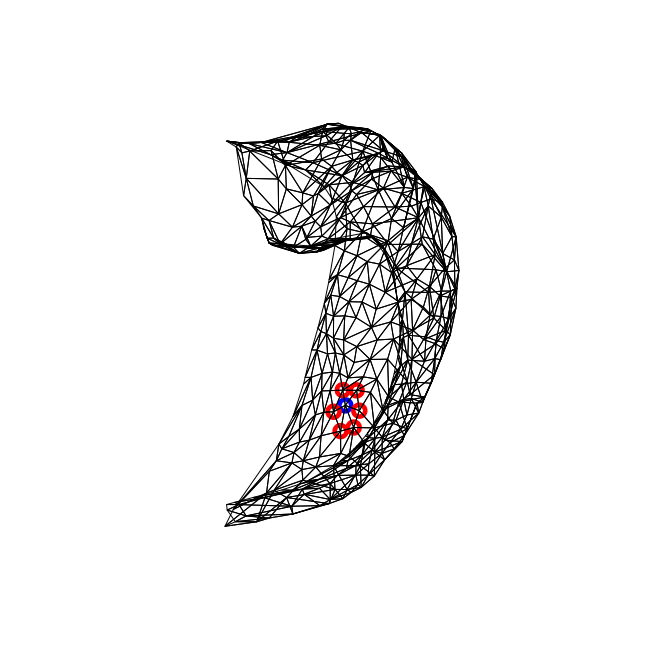

In [37]:
# Here, we take a conconical midthickness surface and highlight one vertex compared with its neighbours
# This is mostly just to illustrate the logic of the method.

from mpl_toolkits.mplot3d import art3d
gii = nib.load(f'../../resources/canonical_surfs/tpl-avg_space-canonical_den-{den}_label-hipp_midthickness.surf.gii')
v = gii.get_arrays_from_intent('NIFTI_INTENT_POINTSET')[0].data
f = gii.get_arrays_from_intent('NIFTI_INTENT_TRIANGLE')[0].data

def plotwire(ax,f,v):
    pc = art3d.Poly3DCollection(v[f], faceColor=[0, 0, 0, 0], edgeColor=[0,0,0,1])
    ax.add_collection(pc)
    ax.set_xlim([np.min(v[:,0]),np.max(v[:,0])])
    ax.set_ylim([np.min(v[:,1]),np.max(v[:,1])])
    ax.set_zlim([np.min(v[:,2]),np.max(v[:,2])])
    ax.view_init(elev=90, azim=-90)
    ax = set_axes_equal(ax)
    ax.axis('off')
    return ax
def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale.  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.
    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().'''
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()
    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)
    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])
    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])
    return ax

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,12), subplot_kw={'projection': "3d"})
plotwire(ax,f,v)
i = 199
frows = np.unique(np.where(np.isin(f,i))[0])
verts = np.unique(f[frows,:])
verts = np.delete(verts,verts==i)
ax.scatter(v[verts,0],v[verts,1],v[verts,2],marker='o',color='none', alpha=1, edgecolor='r', linewidth =12)
ax.scatter(v[i,0],v[i,1],v[i,2],marker='o',color='none', alpha=1, edgecolor='b', linewidth =12)

In [38]:
# Here we define ReHo as the vertex-wise Kendall's W across connected vertices

def kendall_w(expt_ratings):
    # code from https://stackoverflow.com/questions/48893689/kendalls-coefficient-of-concordance-w-in-python
    if expt_ratings.ndim!=2:
        raise 'ratings matrix must be 2-dimensional'
    m = expt_ratings.shape[0] #raters
    n = expt_ratings.shape[1] # items rated
    denom = m**2*(n**3-n)
    rating_sums = np.sum(expt_ratings, axis=0)
    S = n*np.var(rating_sums)
    return 12*S/denom

def calc_reho(ts,F):
    # note ts should be shape VxT
    reho = np.ones((ts.shape[0]))*np.nan
    for v in range(ts.shape[0]):
        # find faces involving this row
        frows = np.unique(np.where(np.isin(F,v))[0])
        # find unique vertices of those faces
        verts = np.unique(F[frows,:])
        # assign that neighbourhood Kendall's W to the vertex in question
        reho[v] = kendall_w(ts[verts,:])
    return reho

In [39]:
# now we can loop through all data and apply

reho = np.ones((nV,len(hemis),len(subs)))*np.nan
for s,sub in enumerate(subs):
    for h,hemi in enumerate(hemis):
        for l,label in enumerate(labels):
            reho[iV[l],h,s] = calc_reho(cdata_hipp[iV[l],h,:,s],f)

/export03/data/opt/BrainSpace/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


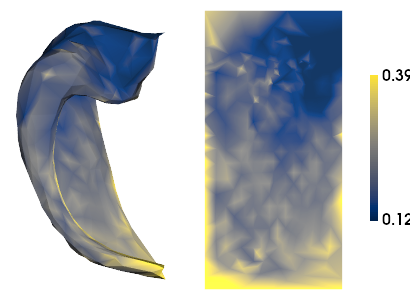

In [40]:
hm.plotting.surfplot_canonical_foldunfold(np.nanmean(reho,axis=(1,2)), den='2mm', hemis=['L'], labels=labels, unfoldAPrescale=True, tighten_cwindow=True, cmap='cividis', share='row', color_bar='right', embed_nb=True)

**Calculate tSNR**

fMRI signal is generally lower for more medial and inferior structures, and those near tissue interfaces like the sinuses and eardrums. Here, we map that onto the hippocampus. (TODO: get volumetric version generated from micapipe)

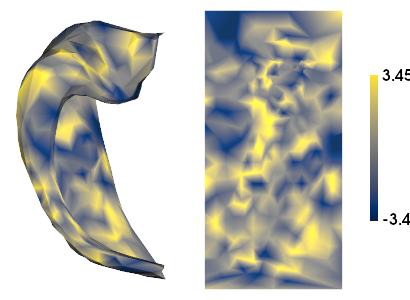

In [41]:
tSNR = np.mean(cdata_hipp,axis=2) / np.std(cdata_hipp,axis=2)
hm.plotting.surfplot_canonical_foldunfold(np.nanmean(tSNR,axis=(1,2)), den='2mm', hemis=['L'], labels=labels, unfoldAPrescale=True, tighten_cwindow=True, cmap='cividis', share='row', color_bar='right', embed_nb=True)

## 3) Functional connectivity of the hippocampus to neocortex

Here we look at FC of each hippocampal vertex to ipsilateral neocortical vertices. 

Note that the neocortical timeseries data is in in a micapipe processed directory and so by default this will be skipped when running this tutorial.

In [ ]:
if not useCheckpoints:

    FC = np.ones((nV,nP,len(hemis),len(subs)))*np.nan
    for s,sub in enumerate(subs):
        neo_ts = nib.load(f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-me_task-rest_bold/surf/sub-{sub}_ses-{ses}_surf-fsLR-32k_desc-timeseries_clean.shape.gii').darrays[0].data
        neo_ts_parc = np.ones((neo_ts.shape[0],nP*2))
        for i in range(nP*2):
            neo_ts_parc[:,i] = np.nanmean(neo_ts[:,parc==(i+1)],axis=1)
        neo_tsL = neo_ts_parc[:,:nP]   
        neo_tsR = neo_ts_parc[:,nP:]
        for h,hemi in enumerate(hemis):
            if hemi == 'L':
                FC[:,:,h,s] = np.corrcoef(cdata_hipp[:,h,:,s],neo_tsL[:timepoints,:].T)[:nV,nV:]
            else:            
                FC[:,:,h,s] = np.corrcoef(cdata_hipp[:,h,:,s],neo_tsR[:timepoints,:].T)[:nV,nV:]
                
    np.save("../checkpoints/MRI-7T-rsfMRI-FC",FC, allow_pickle=True)

In [ ]:
FC = np.load("../checkpoints/MRI-7T-rsfMRI-FC.npy")

FC should skew positive, since negative FC values are generally not interpretable

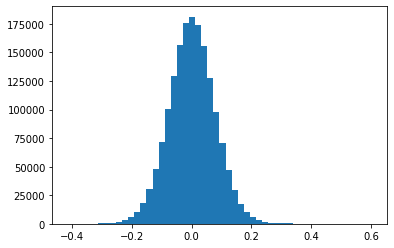

In [44]:
plt.hist(FC.flatten(),bins=50);

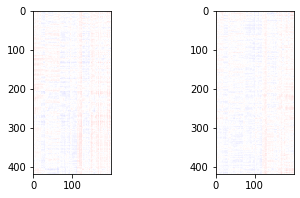

In [45]:
# view left and right FC (nV x nP) after averaging over subjects

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(3*2,3))
ax[0].imshow(np.nanmean(FC[:,:,0,:],axis=(2)), vmin=-.5, vmax=.5, cmap='bwr')
ax[1].imshow(np.nanmean(FC[:,:,1,:],axis=(2)), vmin=-.5, vmax=.5, cmap='bwr')

Here we see that FC is generally positive, both across all FC calculations and after averaging over subjects. This is a good sanity check.

/export03/data/opt/BrainSpace/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


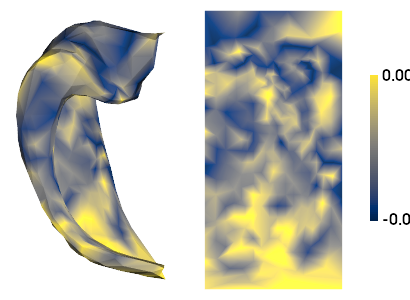

In [46]:
# plot averaging over hemispheres, subjects, and necortical parcels
hm.plotting.surfplot_canonical_foldunfold(np.nanmean(FC,axis=(1,2,3)), den='2mm', hemis=['L'], labels=labels, unfoldAPrescale=True, tighten_cwindow=True, cmap='cividis', share='row', color_bar='right', embed_nb=True)

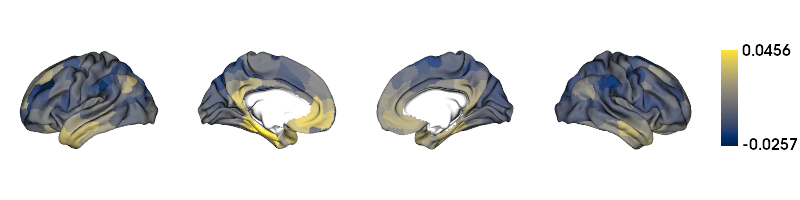

In [47]:
# plot the neocortical counterparts by averaging over subjects and hippocampal vertices
mc = np.ones([c69_inf_lh.n_points + c69_inf_rh.n_points])*np.nan
for h,hemi in enumerate(hemis):
    for i in range(nP):
        mc[parc==(i+1+(h*nP))] = np.nanmean(FC[:,i,h,:],axis=(0,1))
plot_hemispheres( c69_inf_lh,  c69_inf_rh,array_name=np.hsplit(mc,1), 
                 size=(800,200), color_bar=True, cmap='cividis', embed_nb=True,nan_color=(1, 1, 1, 1))

/export03/data/opt/BrainSpace/brainspace/plotting/utils.py:303: RuntimeWarning: All-NaN axis encountered
  a, b = np.nanmin(x), np.nanmax(x)


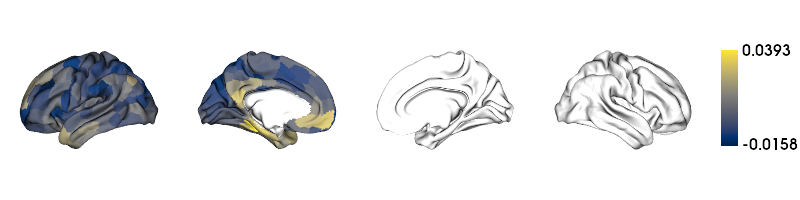

In [48]:
# plot the neocortical counterparts by averaging over subjects, hemispheres, and hippocampal vertices
mc = np.ones([c69_inf_lh.n_points + c69_inf_rh.n_points])*np.nan
for i in range(200):
    mc[parc==(i+1)] = np.nanmean(FC[:,i,:,:],axis=(0,1,2))
plot_hemispheres( c69_inf_lh,  c69_inf_rh,array_name=np.hsplit(mc,1), 
                 size=(800,200), color_bar=True, cmap='cividis', embed_nb=True,nan_color=(1, 1, 1, 1))

## 4) Check consistency for all measures

To make sure our measures are consistent, we will check whether they are correlated across samples (that is, across subjects and hemispheres)

In [49]:
from scipy.stats import ttest_1samp

In [50]:
feats = ["IntTS", "ReHo", "FC"]
mfcorr = []
sdfcorr = []

corr = np.corrcoef(IntTS.reshape((nV,-1)).T)
fcorr = corr[np.triu_indices(len(subs)*2,k=1)]
print(ttest_1samp(fcorr,0,nan_policy='omit'))
mfcorr.append(np.nanmean(fcorr))
sdfcorr.append(np.nanstd(fcorr))

corr = np.corrcoef(reho.reshape((nV,-1)).T)
fcorr = corr[np.triu_indices(len(subs)*2,k=1)]
print(ttest_1samp(fcorr,0,nan_policy='omit'))
mfcorr.append(np.nanmean(fcorr))
sdfcorr.append(np.nanstd(fcorr))

corr = np.corrcoef(FC.reshape((nV,-1)).T)
fcorr = corr[np.triu_indices(len(subs)*2*200,k=1)]
print(ttest_1samp(fcorr,0,nan_policy='omit'))
mfcorr.append(np.nanmean(fcorr))
sdfcorr.append(np.nanstd(fcorr))

TtestResult(statistic=3.4666969448676146, pvalue=0.0006522078530402296, df=189)
TtestResult(statistic=42.46798605750491, pvalue=1.3074381956145864e-98, df=189)
TtestResult(statistic=33.89766818947838, pvalue=7.514400847035185e-252, df=7997999)


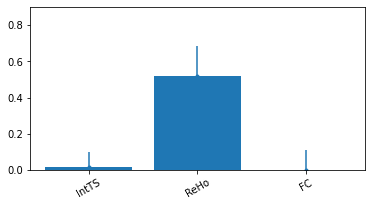

In [51]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3*2,3))
plt.bar(range(3),mfcorr)
plt.errorbar(range(3),mfcorr, yerr=sdfcorr, fmt=".")
plt.xticks(ticks=range(3),labels=feats,rotation=30)
plt.ylim([0,.9]);

Though the inter-subject correlation is somewhat low in IntTS and FC, it is reliably above 0

## 5) Gradients of differential hippocampal FC

Dimensionality reduction allows us to summarize many maps as primary components, or Gradients. Here we will use BrainSpace to compute nonlinear Gradients using diffusion map embedding. Briefly, this typically consists of computing an affinity matrix (e.g. a correlation between all maps) and then grouping them into a few consistent patterns (Gradients). In this case, the affinity matrix is between hippocampal vertices, based on how similar is their neocortical FC. 

In [ ]:
# multimodal gradient map (mGM) decomposition using default parameters 
FCGM = GradientMaps(n_components=5, kernel='normalized_angle')
FCGM.fit(np.nanmean(FC,axis=(2,3)))

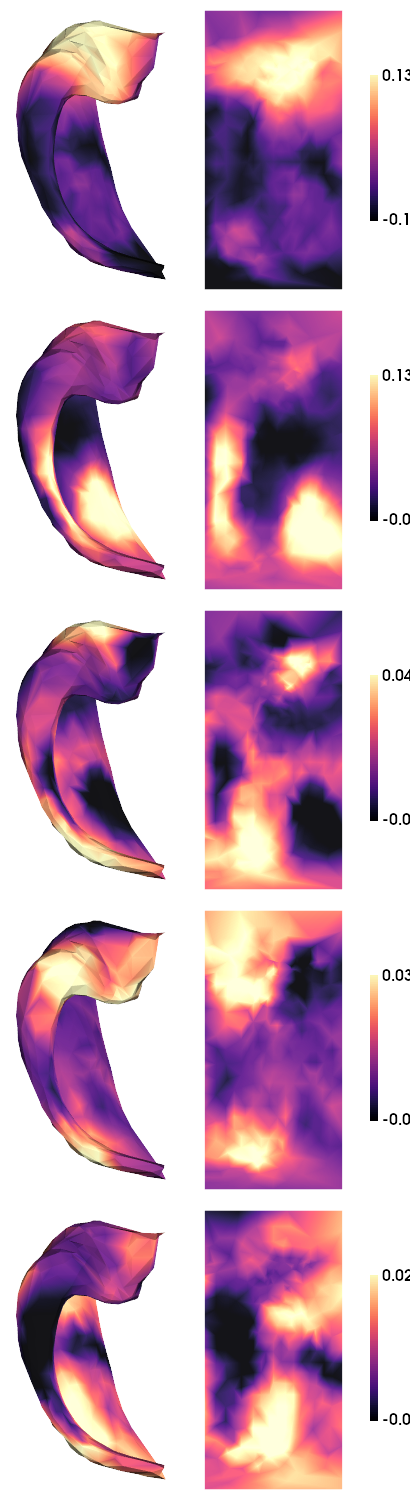

In [ ]:
# As above, we can make a nice plot for each of the resulting gradients
hm.plotting.surfplot_canonical_foldunfold(FCGM.gradients_, den='2mm', hemis=['L'], labels=labels, unfoldAPrescale=True, tighten_cwindow=True, cmap='magma', share='row', color_bar='right', embed_nb=True)

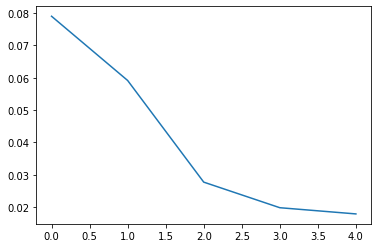

In [ ]:
# we can also see the lambda value (or eigenvalue) for each gradient
plt.plot(FCGM.lambdas_)

In [ ]:
# convert into a percentage of explained variance
FCGM.lambdas_/np.sum(FCGM.lambdas_)

array([0.38785603, 0.2904295 , 0.13625114, 0.09743545, 0.08802788])

To help contextualize how these gradients relate to FC, we can plot the FCs from only to top and the bottom 25% vertices for each gradient.

/export03/data/opt/venv/lib/python3.8/site-packages/brainspace/plotting/utils.py:303: RuntimeWarning: All-NaN axis encountered
  a, b = np.nanmin(x), np.nanmax(x)
/export03/data/opt/venv/lib/python3.8/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


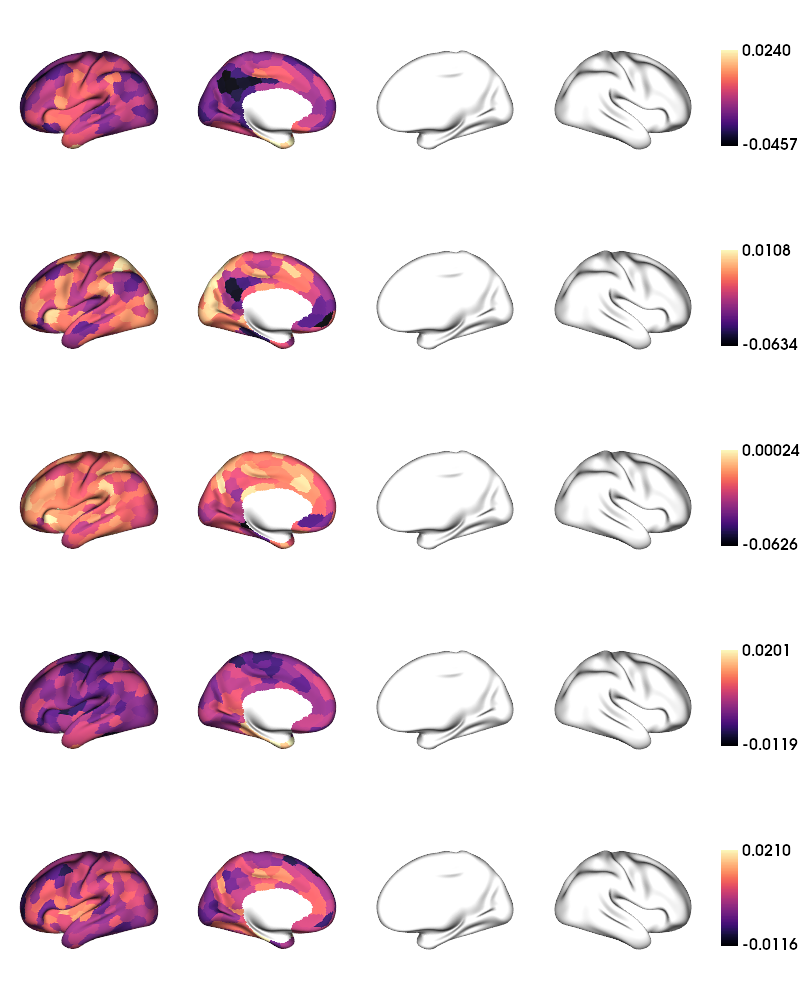

In [ ]:
# look only at FC to the rest of the neocortex for the top-bottom 10% of each gradient

nvertsplit = int(nV*.25)

diffval = np.ones([c69_inf_lh.n_points + c69_inf_rh.n_points,ngrads])*np.nan
botval = np.ones(c69_inf_lh.n_points + c69_inf_rh.n_points)*np.nan
topval = np.ones(c69_inf_lh.n_points + c69_inf_rh.n_points)*np.nan
for g in range(ngrads):
    bot = np.argpartition(gm.gradients_[:,g],nvertsplit)[:nvertsplit]
    top = np.argpartition(gm.gradients_[:,g],-nvertsplit)[-nvertsplit:]
    for i in range(200):
        botval[parc==(i+1)] = np.nanmean(FC[bot,i,:,:],axis=(0,1,2))
        topval[parc==(i+1)] = np.nanmean(FC[top,i,:,:],axis=(0,1,2))
    diffval[:,g] = topval-botval
plot_hemispheres( c69_inf_lh,  c69_inf_rh,array_name=np.hsplit(diffval,ngrads), 
                 size=(800,200*ngrads), color_bar=True, cmap='magma', embed_nb=True,nan_color=(1, 1, 1, 1))

**save**

In [53]:
# save a copy of the 2D map
!mkdir -p ./maps/HippoMaps-initializationMaps/Dataset-MICs
for h,hemi in enumerate(hemis):
    for l,label in enumerate(labels):    
        cdat = np.nanmean(IntTS,axis=2)[iV[l],h]
        data_array = nib.gifti.GiftiDataArray(data=cdat)
        image = nib.gifti.GiftiImage()
        image.add_gifti_data_array(data_array)
        nib.save(image, f'../../maps/HippoMaps-initializationMaps/Dataset-MICs/MRI-7T-rsfMRI-IntTS_average-{len(subs)}_hemi-{hemi}_den-2mm_label-{label}.shape.gii')

In [54]:
# save a copy of the 2D map
for h,hemi in enumerate(hemis):
    for l,label in enumerate(labels):    
        cdat = np.nanmean(reho,axis=2)[iV[l],h]
        data_array = nib.gifti.GiftiDataArray(data=cdat)
        image = nib.gifti.GiftiImage()
        image.add_gifti_data_array(data_array)
        nib.save(image, f'../../maps/HippoMaps-initializationMaps/Dataset-MICs/MRI-7T-rsfMRI-ReHo_average-99_hemi-{hemi}_den-2mm_label-{label}.shape.gii')

In [55]:
# save a copy of the 2D map
for h,hemi in enumerate(hemis):
    for l,label in enumerate(labels):    
        cdat = np.nanmean(FC,axis=(1,3))[iV[l],h]
        data_array = nib.gifti.GiftiDataArray(data=cdat)
        image = nib.gifti.GiftiImage()
        image.add_gifti_data_array(data_array)
        nib.save(image, f'../../maps/HippoMaps-initializationMaps/Dataset-MICs/MRI-7T-rsfMRI-avgFCneocort_average-{len(subs)}_hemi-{hemi}_den-2mm_label-{label}.shape.gii')